# Our task is to predict whether a customer continues with their account or closes it (e.g., churns).

# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings("ignore")

# The Parameters
 Setting random seed, number of folds for cross-validation, and number of estimators for LightGBM.

In [2]:
RAND_VAL=42
num_folds=5 ## Number of folds
n_est=5000 ## Number of estimators

# Read the data
* Read the 'train.csv' file into a DataFrame using pandas
* Display the first few rows of the DataFrame

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


* Read the 'test.csv' file into a DataFrame using pandas
* Display the first few rows of the DataFrame

In [4]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


# Scaling
* Normalize specified columns in the training and test datasets to the range [0, 1].


In [5]:
scale_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']

for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

# TF-IDF Vectorization for surname

In [6]:
# Create a TfidfVectorizer with a maximum of 1000 features
vectorizer = TfidfVectorizer(max_features=1000)

# Transform the 'Surname' column in the training dataset into TF-IDF features
vectors_train = vectorizer.fit_transform(df_train['Surname'])

# Transform the 'Surname' column in the test dataset using the same vectorizer
vectors_test = vectorizer.transform(df_test['Surname'])

# Create a TruncatedSVD (Singular Value Decomposition) object with 3 components
svd = TruncatedSVD(3)

# Apply TruncatedSVD to reduce the dimensionality of TF-IDF features in the training data
x_pca_train = svd.fit_transform(vectors_train)

# Apply the same TruncatedSVD transformation to reduce the dimensionality of TF-IDF features in the test data
x_pca_test = svd.transform(vectors_test)

# Convert to DataFrames
tfidf_df_train = pd.DataFrame(x_pca_train)
tfidf_df_test = pd.DataFrame(x_pca_test)

# Naming columns in the new DataFrames
cols = [('Surname' + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
tfidf_df_train.columns = cols
tfidf_df_test.columns = cols
    
# Reset the index of the DataFrames before concatenation
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Concatenate transformed features with original data
df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
df_test = pd.concat([df_test, tfidf_df_test], axis="columns")

# Feature Engineering
*  Function to derive additional features from the input DataFrame, including
*  senior status, interaction of credit card and active membership, products per tenure,
*  surname length, and one-hot encoding of categorical columns.

In [7]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['len_SurName'] = df['Surname'].apply(lambda x: len(x))
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    
    cat_cols = ['Geography', 'Gender', 'NumOfProducts','AgeCat']
    df=pd.get_dummies(df,columns=cat_cols)
    return df

*  Apply feature engineering using the getFeats function to derive additional features
*  and convert selected columns to float type for both training and test datasets.

In [8]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)

feat_cols=df_train.columns.drop(['id', 'CustomerId', 'Surname','Exited'])
feat_cols=feat_cols.drop(scale_cols)
for c in feat_cols:
    df_train[c] = df_train[c].astype('float')
    df_test[c] = df_test[c].astype('float')
print(feat_cols)
df_train.head()

Index(['Tenure', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2', 'IsSenior',
       'IsActive_by_CreditCard', 'Products_Per_Tenure', 'len_SurName',
       'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'NumOfProducts_1', 'NumOfProducts_2',
       'NumOfProducts_3', 'NumOfProducts_4', 'AgeCat_1', 'AgeCat_2',
       'AgeCat_3', 'AgeCat_4', 'AgeCat_5'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,0,15674932,Okwudilichukwu,668,33.0,3.0,0.00,1.0,0.0,181449.97,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,15749177,Okwudiliolisa,627,33.0,1.0,0.00,1.0,1.0,49503.50,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,15694510,Hsueh,678,40.0,10.0,0.00,1.0,0.0,184866.69,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,15741417,Kao,581,34.0,2.0,148882.54,1.0,1.0,84560.88,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,15766172,Chiemenam,716,33.0,5.0,0.00,1.0,1.0,15068.83,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


*  Split the DataFrame into feature matrix X (selected features) and target variable y.

In [9]:
X=df_train[feat_cols]
y=df_train['Exited']

# Parameters
*  LightGBM hyperparameters for the model, including the number of estimators, maximum depth,
*  learning rate, minimum child weight, minimum child samples, subsample rate, subsample frequency,
*  random state, column subsample rate, and number of leaves.

In [10]:
lgbParams = {'n_estimators': n_est,
 'max_depth': 50,
 'learning_rate': 0.03,
 'min_child_weight': 0.81,
 'min_child_samples': 190,
 'subsample': 0.88,
 'subsample_freq': 2,
 'random_state': RAND_VAL,
 'colsample_bytree': 0.62,
 'num_leaves': 15}

# Feature Importance
*  Create a LightGBM classifier with specified hyperparameters and fit it to the training data.
*  Plot the feature importance based on gain and display the plot.

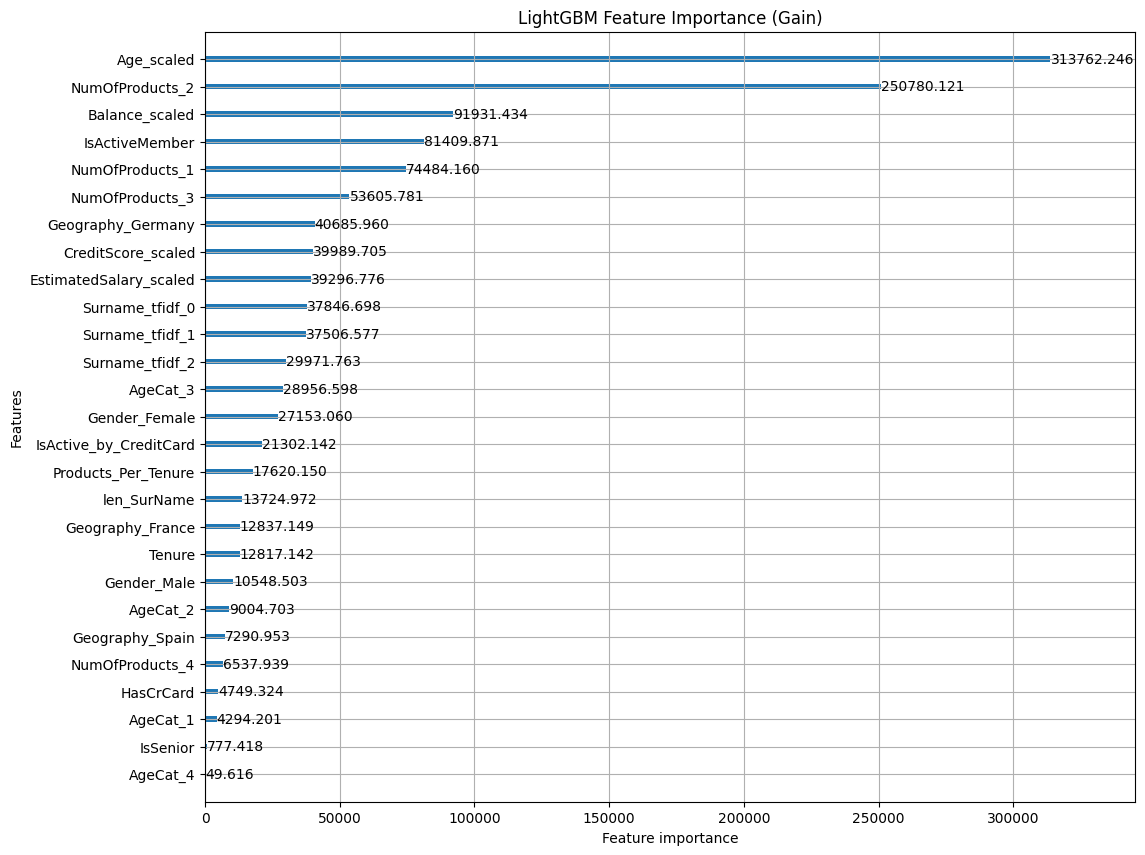

In [11]:
LGB=lgb.LGBMClassifier(**lgbParams)
LGB.fit(X,y)
lgb.plot_importance(LGB, importance_type="gain", figsize=(12,10), title="LightGBM Feature Importance (Gain)")
plt.show()

# Training
*  Implement Stratified K-Fold cross-validation for LightGBM model with specified hyperparameters.
*  Store predicted probabilities for each fold in the test dataset and evaluate AUC for validation sets.

In [12]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    LGB=lgb.LGBMClassifier(**lgbParams)
    LGB.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        early_stopping_rounds=100,verbose=200)
    
    y_pred_val = LGB.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = LGB.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

[200]	valid_0's auc: 0.889952	valid_0's binary_logloss: 0.320591
[400]	valid_0's auc: 0.892274	valid_0's binary_logloss: 0.316653
[600]	valid_0's auc: 0.892901	valid_0's binary_logloss: 0.315562
[800]	valid_0's auc: 0.893285	valid_0's binary_logloss: 0.314873
[1000]	valid_0's auc: 0.893453	valid_0's binary_logloss: 0.314517
[1200]	valid_0's auc: 0.893566	valid_0's binary_logloss: 0.314254
[1400]	valid_0's auc: 0.893628	valid_0's binary_logloss: 0.314138
AUC for fold  0 :  0.8936346439106934
----------------
[200]	valid_0's auc: 0.89017	valid_0's binary_logloss: 0.319539
[400]	valid_0's auc: 0.892616	valid_0's binary_logloss: 0.315787
[600]	valid_0's auc: 0.893429	valid_0's binary_logloss: 0.314595
[800]	valid_0's auc: 0.893962	valid_0's binary_logloss: 0.31386
[1000]	valid_0's auc: 0.894275	valid_0's binary_logloss: 0.313384
[1200]	valid_0's auc: 0.894406	valid_0's binary_logloss: 0.313155
[1400]	valid_0's auc: 0.894597	valid_0's binary_logloss: 0.3129
[1600]	valid_0's auc: 0.894654	va

# Evaluation
* Calculate and print the mean AUC (Area Under the ROC Curve) from cross-validation results.

In [13]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.894421813659835)

# Prediction and Submission
*  Calculate the mean of predictions across folds for final predictions.
*  Create a submission DataFrame with 'id' and corresponding predicted 'Exited' probabilities.
*  Display the first few rows of the submission DataFrame.

In [14]:
y_pred = test_preds.mean(axis=0)
df_sub = df_test[['id']]
df_sub['Exited'] = y_pred
df_sub.head()

,id,Exited
0,165034,0.018304
1,165035,0.720601
2,165036,0.030218
3,165037,0.230760
4,165038,0.375182


In [15]:
df_sub.to_csv("submission.csv",index=False)

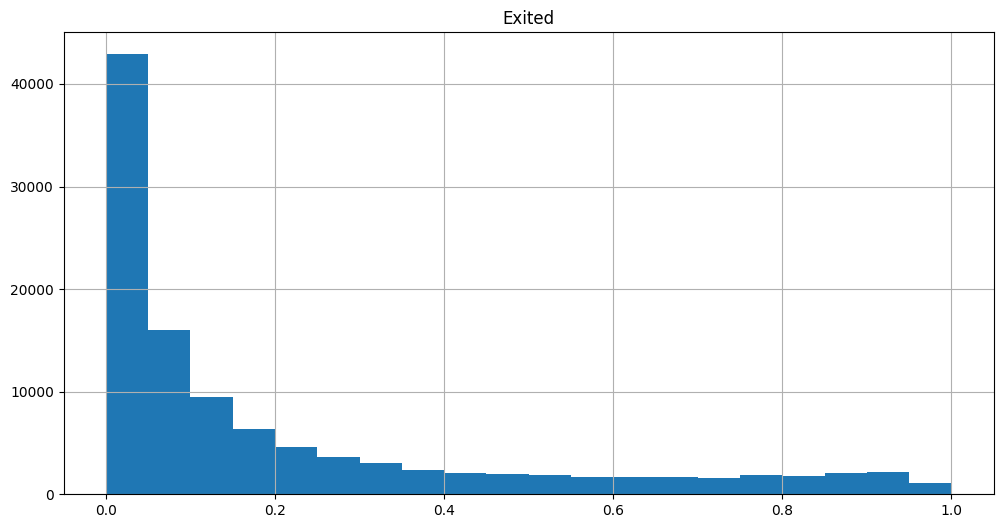

In [16]:
df_sub.hist(column='Exited', bins=20, range=[0,1],figsize=(12,6))
plt.show()

@Credit: https://www.kaggle.com/code/aspillai/bank-churn-dataset-classification-lightgbm/notebook